In [1]:
# General libs
import os                             
import random 
from PIL import Image
import matplotlib.pyplot as plt     
%matplotlib inline   
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import pandas as pd             
import numpy as np  
!pip install opencv-python
import cv2                            

# ML libs
!pip install keras
!pip install tensorflow
import keras.backend as K
from keras import regularizers
from keras.models import Model, Sequential  
from keras.layers import Input, Flatten, Dropout, Dense, BatchNormalization
from keras.layers import LeakyReLU, PReLU, Activation, Conv2D, SeparableConv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History, EarlyStopping
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


True


In [2]:
input_path = './chest_xray/'

counter_normal_train = len(os.listdir(input_path + 'train' + '/NORMAL'))
counter_infect_train = len(os.listdir(input_path + 'train' + '/PNEUMONIA'))

counter_normal_test = len(os.listdir(input_path + 'test' + '/NORMAL'))
counter_infect_test = len(os.listdir(input_path + 'test' +  '/PNEUMONIA'))

counter_normal_val = len(os.listdir(input_path + 'val' + '/NORMAL'))
counter_infect_val = len(os.listdir(input_path + 'val' +  '/PNEUMONIA'))

counter_all = counter_normal_train + counter_infect_train + counter_normal_test + counter_infect_test + counter_normal_val +  counter_infect_val
counter_all_healthy = counter_normal_train + counter_normal_test + counter_normal_val
counter_all_infect = counter_infect_train + counter_infect_test + counter_infect_val

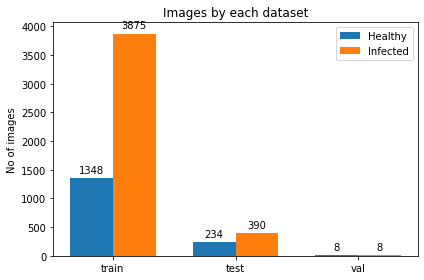

In [3]:
labels = ['train', 'test', 'val']
healthy_means = [counter_normal_train, counter_normal_test, counter_normal_val]
infected_means = [counter_infect_train, counter_infect_test, counter_infect_val]

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy_means, width, label='Healthy')
rects2 = ax.bar(x + width/2, infected_means, width, label='Infected')
ax.set_ylabel('No of images')
ax.set_title('Images by each dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

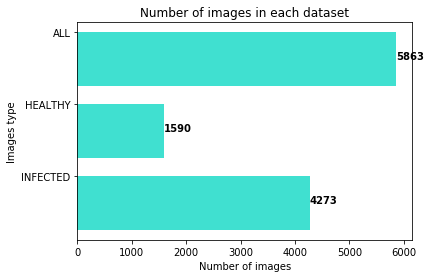

In [4]:
x = [u'INFECTED', u'HEALTHY', u'ALL']
y = [counter_all_infect, counter_all_healthy, counter_all]

fig, ax = plt.subplots()    
width = 0.75  
ind = np.arange(len(y))  
ax.barh(ind, y, width, color="turquoise")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Number of images in each dataset')
plt.xlabel('Number of images')
plt.ylabel('Images type')      

plt.savefig(os.path.join('pneumonia_class.png'), dpi=400, format='png', bbox_inches='tight') 

for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

In [5]:
def process_images(dimensions, batch):
  train_datagen =    ImageDataGenerator(rescale = 1./255, 
                                        zca_whitening=False, 
                                        horizontal_flip = False, 
                                        zoom_range = 0.5, 
                                        vertical_flip = True)
  test_val_datagen = ImageDataGenerator (rescale= 1./255)

  train_gen = train_datagen.flow_from_directory(directory = input_path + 'train', 
                                                target_size = (dimensions, dimensions), 
                                                batch_size = batch, 
                                                class_mode = 'binary', 
                                                shuffle = True)
  test_gen = test_val_datagen.flow_from_directory(directory = input_path + 'test', 
                                                  target_size = (dimensions, dimensions), 
                                                  batch_size = batch, 
                                                  class_mode = 'binary', 
                                                  shuffle = True)

  test_data = []
  test_labels = []

  for condition in ['/NORMAL/', '/PNEUMONIA/']:
    for image in (os.listdir(input_path + 'test' + condition)):
      image = plt.imread(input_path + 'test' + condition + image)
      image = cv2.resize(image, (dimensions, dimensions))
      image = np.dstack([image, image, image])
      image = image.astype('float32') / 255
      if condition == '/NORMAL/':
        label = 0
      elif condition == '/PNEUMONIA/':
        label = 1
        
      test_data.append(image)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return train_gen, test_gen, test_data, test_labels


In [12]:
dimensions = 150
epochs = 10
batch = 16

train_gen, test_gen, test_data, test_labels = process_images(dimensions, batch)

Found 5223 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same', input_shape=(150,150,3)))
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Creating a model and compiling
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics =['accuracy'])

# Callbacks
#tensor_board = TensorBoard(log_dir='graph.metrics', 
#                                           histogram_freq=0, 
#                                           write_graph=True, 
#                                           write_images=True)
checkpoint = ModelCheckpoint(filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             verbose = 1,
                             mode = 'auto',
                             save_best_only=True, 
                             save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=1)
history = History()

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               min_delta=0.1, 
                               patience=3) 
#zca whitening and early stopping, promjena i testiranje

In [14]:
hist = model.fit_generator(train_gen, 
                           steps_per_epoch = train_gen.samples // batch, 
                           epochs = epochs, 
                           validation_data = test_gen, 
                           validation_steps = test_gen.samples // batch, 
                           callbacks = [checkpoint, lr_reduce])


Epoch 1/11
326/326 [==============================] - 220s 674ms/step - loss: 1.2069 - accuracy: 0.8049 - val_loss: 0.6714 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.67137, saving model to weights.01-0.67.hdf5
Epoch 2/11
326/326 [==============================] - 226s 693ms/step - loss: 0.4264 - accuracy: 0.8454 - val_loss: 0.4696 - val_accuracy: 0.6282

Epoch 00002: val_loss improved from 0.67137 to 0.46962, saving model to weights.02-0.47.hdf5
Epoch 3/11
326/326 [==============================] - 213s 654ms/step - loss: 0.3826 - accuracy: 0.8708 - val_loss: 0.4445 - val_accuracy: 0.7676

Epoch 00003: val_loss improved from 0.46962 to 0.44455, saving model to weights.03-0.44.hdf5
Epoch 4/11
326/326 [==============================] - 212s 650ms/step - loss: 0.3645 - accuracy: 0.8815 - val_loss: 0.2715 - val_accuracy: 0.8734

Epoch 00004: val_loss improved from 0.44455 to 0.27149, saving model to weights.04-0.27.hdf5
Epoch 5/11
326/326 [========================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


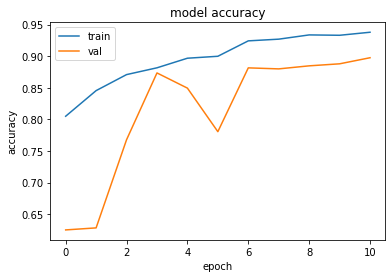

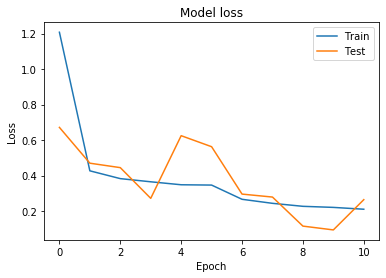

In [15]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
predict_probs = model.predict(test_data)
predict_classes = model.predict_classes(test_data, verbose=0)

predict_probs = predict_probs[:, 0]
predict_classes = predict_classes[:, 0]

print ('\nTest metrics\n----------------')
cm = confusion_matrix(test_labels, np.round(predict_probs))
print ('Confusion matrix\n', cm)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, predict_classes) * 100
print('Accuracy: {}%'.format(np.round(accuracy,2)))
# precision tp / (tp + fp)
precision = precision_score(test_labels, predict_classes) * 100
print('Precision: {}%'.format(np.round(precision,2)))
# recall: tp / (tp + fn)
recall = recall_score(test_labels, predict_classes) * 100
print('Recall: {}%'.format(np.round(recall,2)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, predict_classes) * 100
print('F1-score: {}%'.format(np.round(2* precision * recall / (precision + recall),2)))

auc = roc_auc_score(test_labels, predict_probs)
print('ROC AUC: %f' % auc)

print('\nTrain metric\n----------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


Test metrics
----------------
Confusion matrix
 [[175  59]
 [ 10 380]]
Accuracy: 88.94%
Precision: 86.56%
Recall: 97.44%
F1-score: 91.68%
ROC AUC: 0.959763

Train metric
----------------
Train accuracy: 93.78
